In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
zip_path = '/content/drive/MyDrive/UAP-Machine-Learning/images-20241222T095027Z-001.zip'  # Replace with your ZIP file path
extract_path = '/content/drive/MyDrive/UAP-Machine-Learning'  # Replace with desired extraction path

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [3]:
!pip install silence_tensorflow

  Preparing metadata (setup.py) ... done
  Created wheel for silence_tensorflow: filename=silence_tensorflow-1.2.3-py3-none-any.whl size=6749 sha256=5a226a0c66db265561d995b33bd43bf1d4959d8ec49bc93aeb236471ca9b0c8c
  Stored in directory: /root/.cache/pip/wheels/2e/91/a1/2d32c0ea21439c6367fe1acaa2d3a0377a95ae51cf47c13521
Successfully built silence_tensorflow


In [4]:
# A function to avoid tensorflow warnings
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

# **IMPORT LIBRARY**

In [5]:
import os
import cv2
import random
import shutil
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from shutil import copy2
from PIL import Image
from termcolor import colored
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix

In [6]:
print(tf.__version__)

2.17.1


In [7]:
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

# **PREPROCESSING DATA**

- resize 224x224

In [8]:
def resize_image(input_path, output_path, size=(224, 224)):
    """Resize image to the specified size and save it to the output path."""
    with Image.open(input_path) as img:
        # Konversi gambar ke mode RGB jika gambar berada dalam mode RGBA atau mode lainnya
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img = img.resize(size, Image.LANCZOS)
        img.save(output_path)

def process_directory(input_dir, output_dir, size=(224, 224)):
    """Process all images in the input directory and save them to the output directory."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith(('jpg', 'jpeg', 'png')):
                input_file_path = os.path.join(root, file)
                output_file_path = os.path.join(output_dir, os.path.relpath(input_file_path, input_dir))

                # Create the output directory if it does not exist
                output_file_dir = os.path.dirname(output_file_path)
                if not os.path.exists(output_file_dir):
                    os.makedirs(output_file_dir)

                # Resize and save the image
                resize_image(input_file_path, output_file_path, size)

In [9]:
input_base_dir = '/content/drive/MyDrive/UAP-Machine-Learning/images'
output_base_dir = '/content/drive/MyDrive/UAP-Machine-Learning/data224x224'

process_directory(input_base_dir, output_base_dir, size=(224, 224))

print("Image resizing completed!")

Image resizing completed!


- Split data

In [11]:
dir_data_224 = '/content/drive/MyDrive/UAP-Machine-Learning/data224x224'
dir_tvt = '/content/drive/MyDrive/UAP-Machine-Learning/data-tvt'

In [12]:
deases_class = [dir for dir in os.listdir(dir_data_224) if os.path.isdir(os.path.join(dir_data_224, dir))]
print(deases_class)

['heat-sink', 'limiter-clipper', 'attenuator', 'memory-chip', 'filament', 'solenoid', 'cartridge-fuse', 'step-down-transformer', 'jumper-cable', 'armature', 'potentiometer', 'semiconductor-diode', 'microchip', 'LED', 'microprocessor', 'pulse-generator', 'clip-lead', 'Electrolytic-capacitor']


In [13]:
# Loop over each vegetable directory
for desases in deases_class:
    print(desases)
    deases_path = os.path.join(dir_data_224, desases) #\data224x224\Coccidiosis
    all_image_paths = []

    if os.path.exists(deases_path):
        paths = [os.path.join(deases_path, f) for f in os.listdir(deases_path) if os.path.isfile(os.path.join(deases_path, f))]
        all_image_paths.extend(paths)

    random.shuffle(all_image_paths)

    # Split images into train, validation, and test sets
    num_images = len(all_image_paths)
    train_size = int(0.8 * num_images)
    valid_size = int(0.1 * num_images)
    test_size = num_images - train_size - valid_size

    train_paths = all_image_paths[:train_size]
    valid_paths = all_image_paths[train_size:train_size + valid_size]
    test_paths = all_image_paths[train_size + valid_size:]

    # Copy images
    for path in train_paths:
        dst_dir = os.path.join(dir_tvt, 'train', desases)
        if not os.path.exists(dst_dir):
            os.makedirs(dst_dir)
        copy2(path, os.path.join(dst_dir, os.path.basename(path)))

    for path in valid_paths:
        dst_dir = os.path.join(dir_tvt, 'validation', desases)
        if not os.path.exists(dst_dir):
            os.makedirs(dst_dir)
        copy2(path, os.path.join(dst_dir, os.path.basename(path)))

    for path in test_paths:
        dst_dir = os.path.join(dir_tvt, 'test', desases)
        if not os.path.exists(dst_dir):
            os.makedirs(dst_dir)
        copy2(path, os.path.join(dst_dir, os.path.basename(path)))


heat-sink
limiter-clipper
attenuator
memory-chip
filament
solenoid
cartridge-fuse
step-down-transformer
jumper-cable
armature
potentiometer
semiconductor-diode
microchip
LED
microprocessor
pulse-generator
clip-lead
Electrolytic-capacitor


# **IMPORT DATA**

In [14]:
train_dir = os.path.join(dir_tvt, 'train')
validation_dir = os.path.join(dir_tvt, 'validation')
test_dir = os.path.join(dir_tvt, 'test')

# **Count data and classes**

In [15]:
def num_of_classes(folder_dir, folder_name) :
    classes = [class_name for class_name in os.listdir(train_dir)]
    print(colored(f'number of classes in {folder_name} folder : {len(classes)}', 'blue', attrs=['bold']))

In [16]:
num_of_classes(train_dir, 'train')
num_of_classes(validation_dir, 'validation')
num_of_classes(test_dir, 'test')

number of classes in train folder : 18
number of classes in validation folder : 18
number of classes in test folder : 18


In [17]:
def plot_num_of_samples(path, labeling) :
  classes = [class_name for class_name in os.listdir(path)]
  count = []
  for class_name in classes :
      count.append(len(os.listdir(os.path.join(path, class_name))))

  plt.figure(figsize=(15, 4))
  ax = sns.barplot(x=classes, y=count, color='Green')
  # plt.xticks(rotation=285)
  for i in ax.containers:
      ax.bar_label(i,)
  plt.title(labeling, fontsize=25, fontweight='bold')
  plt.xlabel('Labels', fontsize=15)
  plt.ylabel('Counts', fontsize=15)
  plt.yticks(np.arange(0, 1500, 100))
  plt.show()

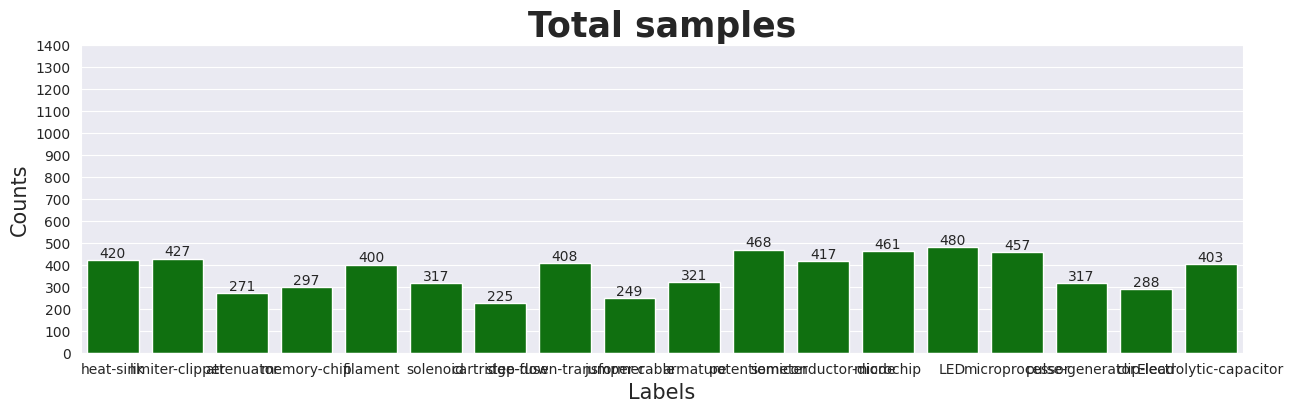

In [18]:
plot_num_of_samples(dir_data_224, 'Total samples')

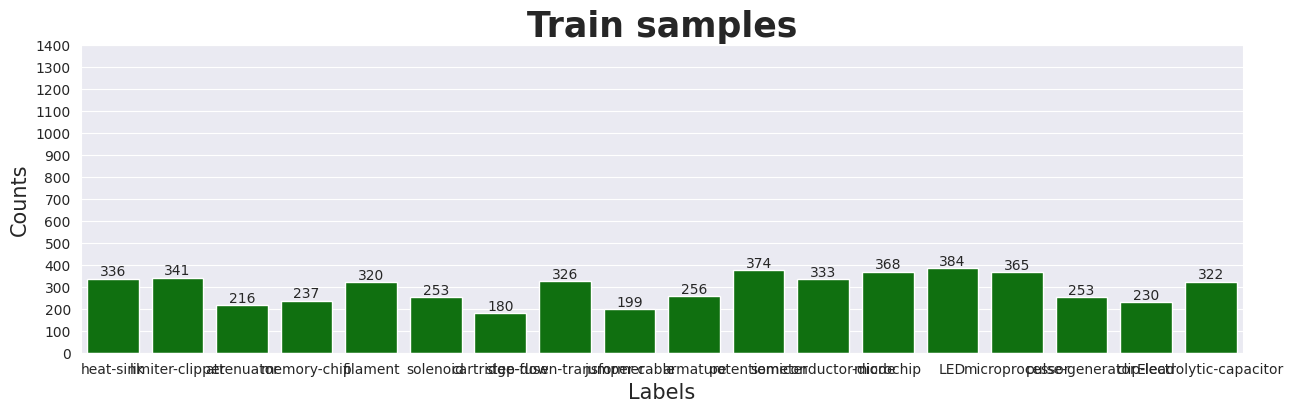

In [19]:
plot_num_of_samples(train_dir, 'Train samples')

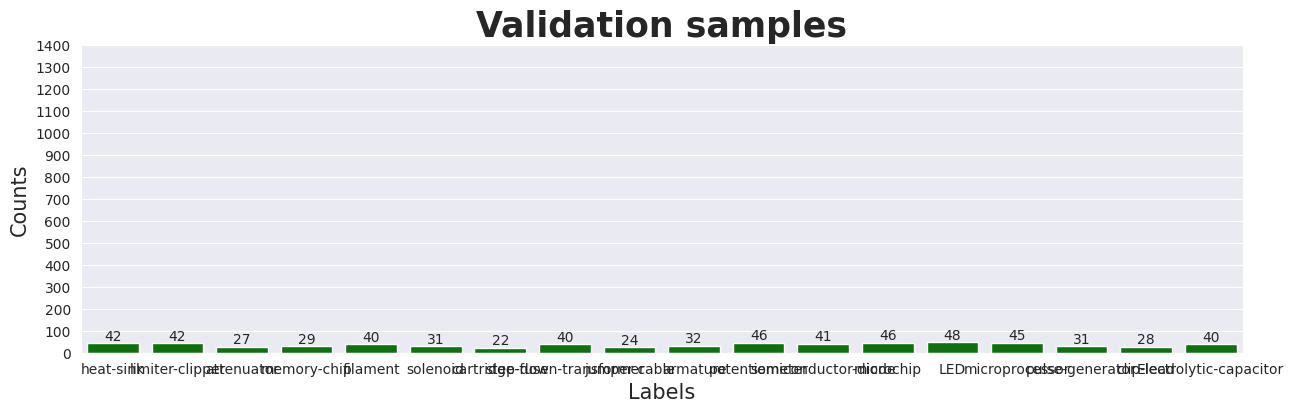

In [20]:
plot_num_of_samples(validation_dir, 'Validation samples')

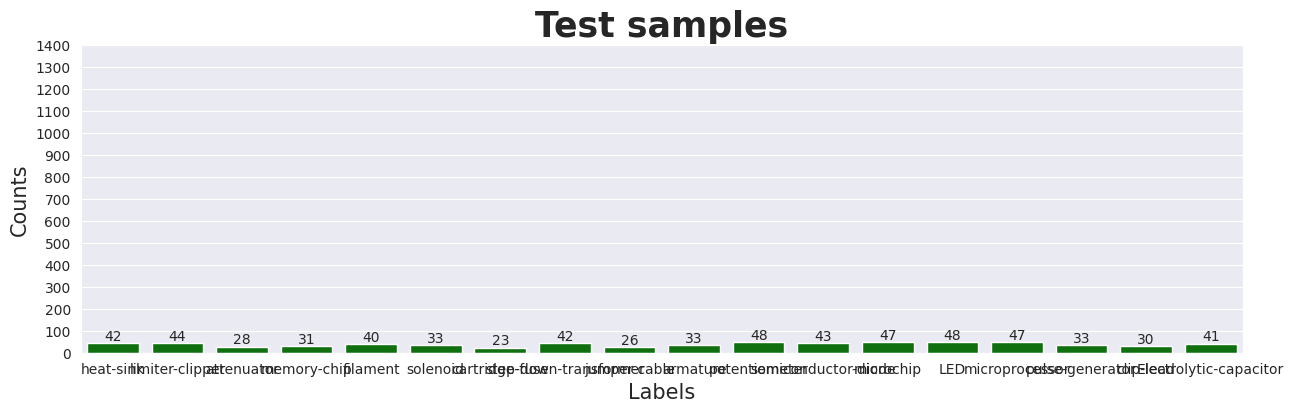

In [21]:
plot_num_of_samples(test_dir, 'Test samples')

# **Convert data to a DataFrame**

In [22]:
# A function to return DataFrame
classes = [class_name for class_name in os.listdir(train_dir)]
count = []
def create_df(folder_path) :
    all_images = []
    for class_name in classes :
        class_path = os.path.join(folder_path, class_name)
        all_images.extend([(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)])
    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df

In [23]:
train_df = create_df(train_dir)
validation_df = create_df(validation_dir)
test_df = create_df(test_dir)

In [24]:
print(colored(f'Total Sample : {len(train_df) + len(validation_df) + len(test_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples in train : {len(train_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples in validation : {len(validation_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples test : {len(test_df)}', 'blue', attrs=['bold']))

Total Sample : 6626
Number of samples in train : 5293
Number of samples in validation : 654
Number of samples test : 679


# **visualisasi image**

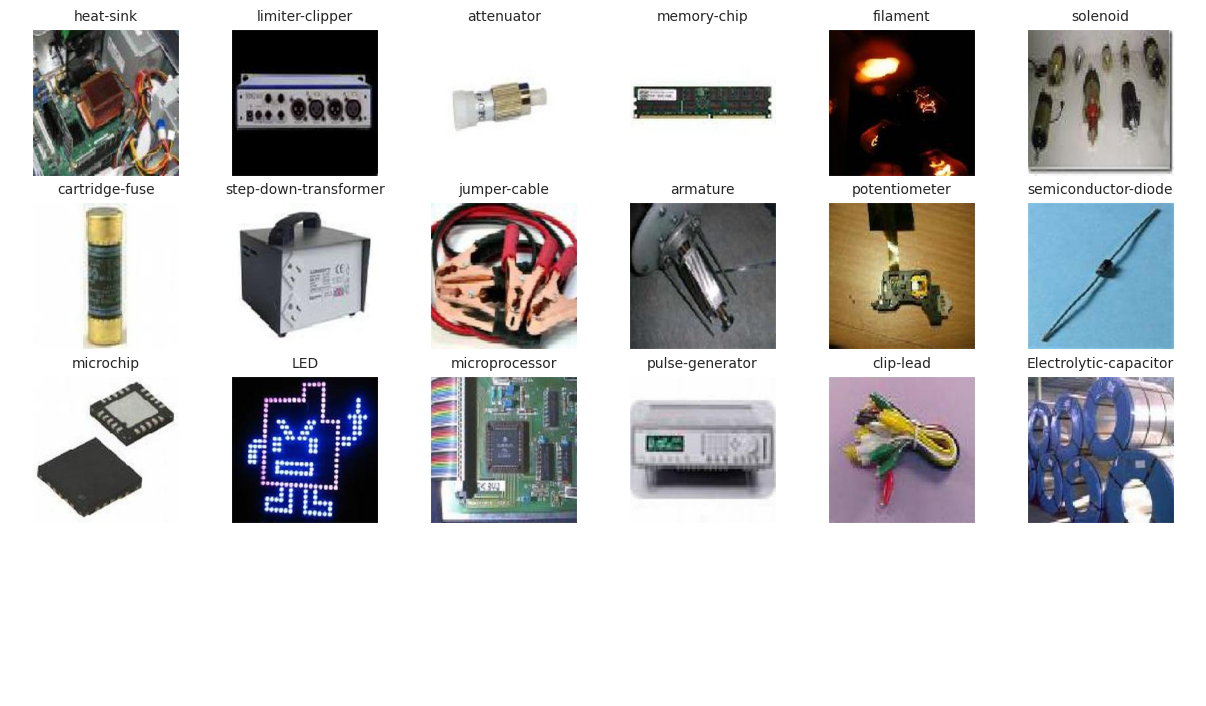

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming train_df is already defined
df_unique = train_df.copy().drop_duplicates(subset=["label"]).reset_index()

# Number of unique labels
num_unique_labels = df_unique.shape[0]

# Calculate the number of rows and columns needed for subplots
nrows = (num_unique_labels // 6) + 1
ncols = min(num_unique_labels, 6)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 7),
                         subplot_kw={'xticks': [], 'yticks': []})

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, ax in enumerate(axes[:num_unique_labels]):
    ax.imshow(plt.imread(df_unique.file_path[i]))
    ax.set_title(df_unique.label[i], fontsize=10)

# Hide any remaining subplots if there are any
for ax in axes[num_unique_labels:]:
    ax.axis('off')

plt.tight_layout(pad=0.5)
plt.show()


# **Data generators**

In [26]:
# Train generator

train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Scaled images in range 0 to 1
    rotation_range=20,              # Rorate images by factor 20 degree
    zoom_range=0.1,                 # Zoom in and out images by 10%
    horizontal_flip=True,           # Allow horizontal flipping
    vertical_flip=True,              # Allow vertical flipping
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,             # Target data
    x_col='file_path',              # X column
    y_col='label',                  # y column
    target_size=(224, 224),         # Resize images  to
    color_mode='rgb',               # Color mode
    class_mode='categorical',       # type of model
    batch_size=32,
    shuffle=True,
    seed=42,
)

Found 5293 validated image filenames belonging to 18 classes.


In [27]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False
)

Found 654 validated image filenames belonging to 18 classes.


In [28]:
# Test generator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False
)

Found 679 validated image filenames belonging to 18 classes.


# **Build MobileNetV2 model**

In [29]:
pre_trained_model = MobileNetV2(
    input_shape=(224, 224, 3),            # Input image size
    include_top=False,                    # model not include top layer
    weights='imagenet',                   # weights type
    classifier_activation='softmax',      # activation function
    pooling='avg'                         # type of pooling layer
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# **Freeze MobileNetV2 layers**

In [30]:
# Name of layers in MobileNetV2
for layer in pre_trained_model.layers :
    print(layer.name)


input_layer
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
block_6_ex

In [31]:
# Freeze all layers, except last layer
# The goal is to train just last layer of pre trained model

pre_trained_model.trainable = True
set_trainable = False

for layer in pre_trained_model.layers :
    if layer.name == 'block_16_expand' :
        set_trainable = True
    if set_trainable :
        layer.trainable = True
    else :
        layer.trainable = False

# **Mendefinisikan model**

In [32]:
# Add custom layers on top of the base model
model = models.Sequential()
model.add(pre_trained_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(18, activation='softmax'))


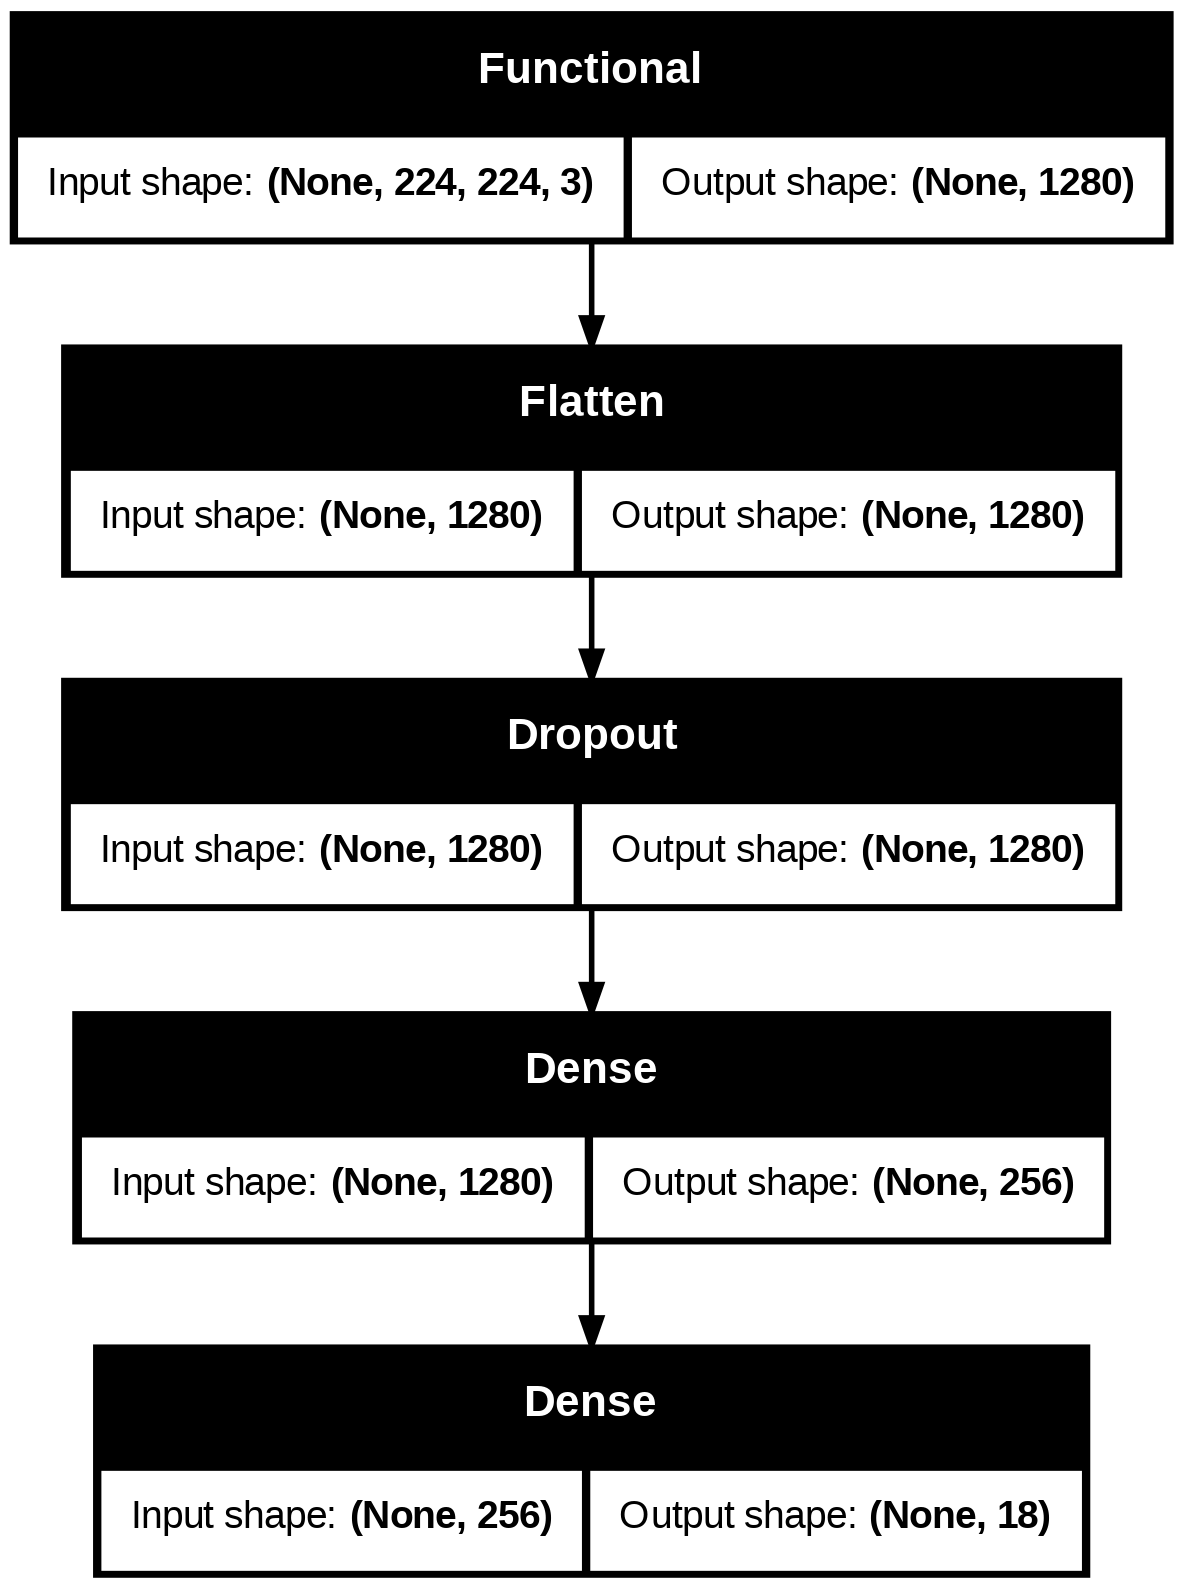

In [33]:
plot_model(model, show_shapes=True, show_layer_names=False, dpi=200)

In [34]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 1280)                │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 18)                  │           4,626 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,590,546 (9.88 MB)

 Trainable params: 1,218,642 (4.65 MB)

 Non-trainable params: 1,371,904 (5.23 MB)

# **Compile Model**

In [35]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [36]:
# Model CheckPoint
checkpoint_cb = ModelCheckpoint(
    'my_model.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Early Stoping
earlystop_cb = EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor='val_loss',
    mode='min'
)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    verbose=1,
    mode='min'
)

# **Train Model**

In [37]:
history = model.fit(
    train_generator,
    epochs= 100,
    batch_size=32,
    verbose= 1,
    callbacks= [checkpoint_cb, earlystop_cb, reduce_lr],
    validation_data= validation_generator,
    validation_steps= None,
    shuffle= False
)

Epoch 1/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.2578 - loss: 2.4466
Epoch 1: val_loss improved from inf to 1.61727, saving model to my_model.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 110s 570ms/step - accuracy: 0.2585 - loss: 2.4440 - val_accuracy: 0.4786 - val_loss: 1.6173 - learning_rate: 1.0000e-04
Epoch 2/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.5481 - loss: 1.4047
Epoch 2: val_loss improved from 1.61727 to 1.57960, saving model to my_model.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 82s 492ms/step - accuracy: 0.5481 - loss: 1.4046 - val_accuracy: 0.5031 - val_loss: 1.5796 - learning_rate: 1.0000e-04
Epoch 3/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.6130 - loss: 1.1992
Epoch 3: val_loss improved from 1.57960 to 1.56781, saving model to my_model.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 84s 502ms/step - accuracy: 0.6129 - loss: 1.1992 - val_accuracy: 0.5336 - val_loss: 1.5678 - learning_rate: 1.0000e-04
Epoch 4/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s

# **Plot the result of training**

In [38]:
# Convert resutl of training to a DataFrame
result_df = pd.DataFrame(history.history)
result_df.tail()

,accuracy,loss,val_accuracy,val_loss,learning_rate
24,0.804837,0.582965,0.623853,1.222385,6.250000e-06
25,0.816361,0.566392,0.622324,1.222398,3.125000e-06
26,0.808048,0.580685,0.622324,1.222161,1.562500e-06
27,0.804837,0.577486,0.620795,1.222064,7.812500e-07
28,0.808237,0.567129,0.620795,1.221988,3.906250e-07


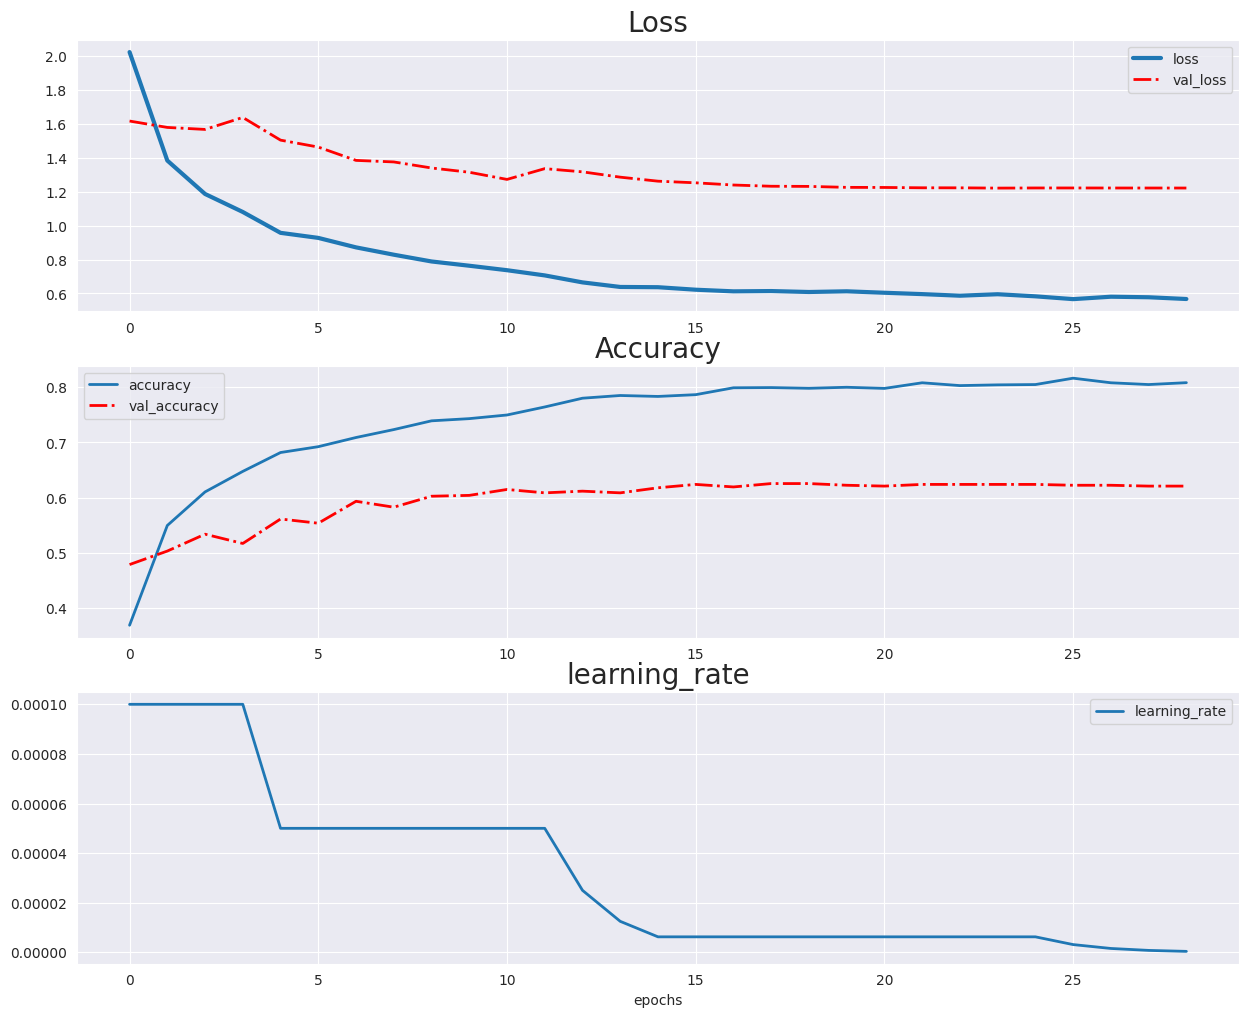

In [39]:
x = np.arange(len(result_df))
fig, ax = plt.subplots(3, 1, figsize=(15, 12))
#  AX0 : Loss
ax[0].plot(x, result_df.loss, label='loss', linewidth=3)
ax[0].plot(x, result_df.val_loss, label='val_loss', linewidth=2, ls='-.', c='r')
ax[0].set_title('Loss', fontsize=20)
ax[0].legend()

#  AX1 : Loss
ax[1].plot(x, result_df.accuracy, label='accuracy', linewidth=2)
ax[1].plot(x, result_df.val_accuracy, label='val_accuracy', linewidth=2, ls='-.', c='r')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].legend()

#  AX2 : Loss
ax[2].plot(x, result_df.learning_rate, label='learning_rate', linewidth=2)
ax[2].set_title('learning_rate', fontsize=20)
ax[2].set_xlabel('epochs')
ax[2].legend()


plt.sharex=True


plt.show()

# **MODEL PREDICTION TEST DATASET**

In [40]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Electrolytic-capacitor
1 : LED
2 : armature
3 : attenuator
4 : cartridge-fuse
5 : clip-lead
6 : filament
7 : heat-sink
8 : jumper-cable
9 : limiter-clipper
10 : memory-chip
11 : microchip
12 : microprocessor
13 : potentiometer
14 : pulse-generator
15 : semiconductor-diode
16 : solenoid
17 : step-down-transformer


In [41]:
predictions = model.predict(test_generator)

22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 282ms/step


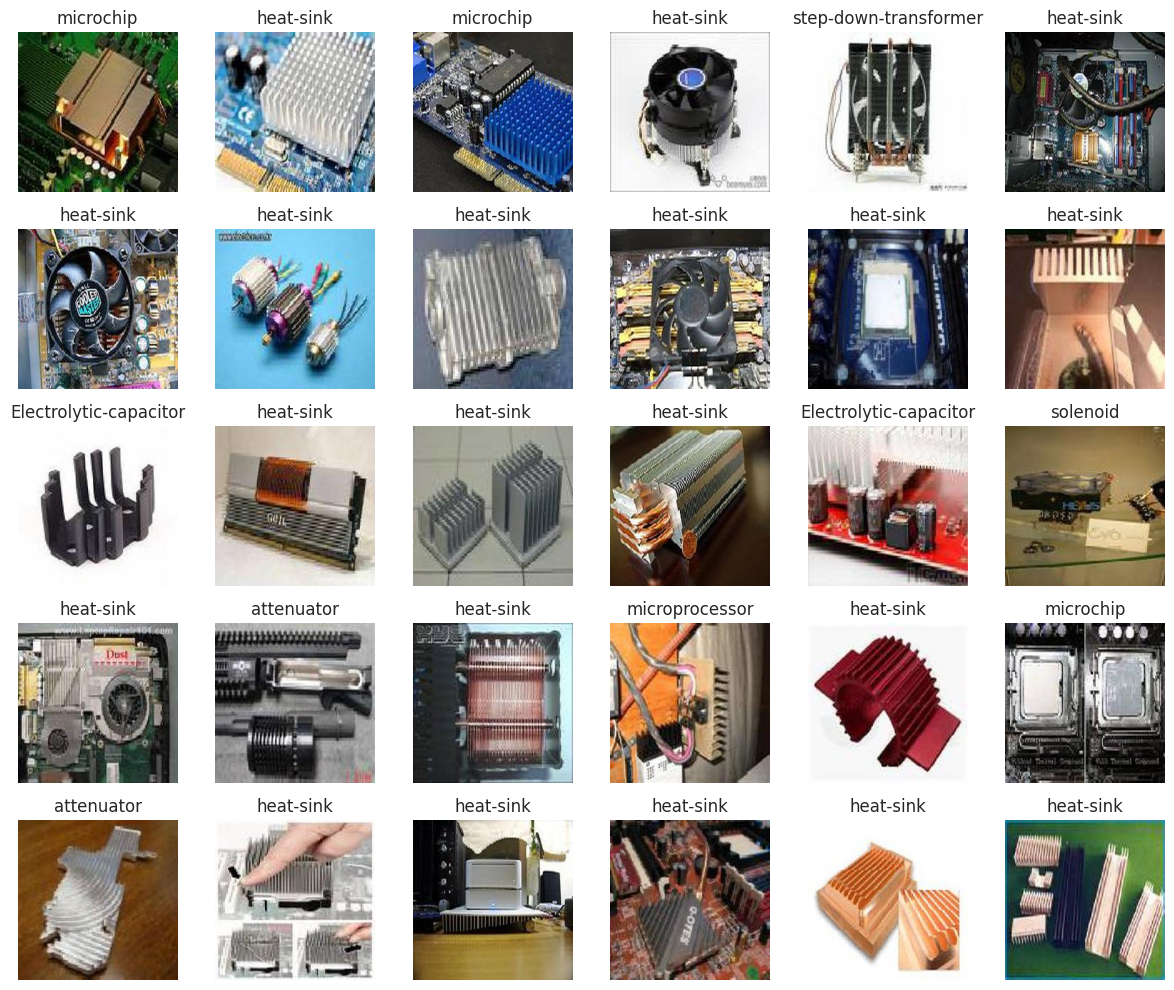

In [42]:
fig, ax = plt.subplots(nrows=5, ncols=6, figsize=(12, 10))
idx = 0

for i in range(5):
    for j in range(6):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
# plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [43]:
test_loss, test_accuracy = model.evaluate(test_generator, batch_size=32)

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.6770 - loss: 0.9814


In [44]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy} -> {test_accuracy*100:.2f}%")

Test Loss:     1.0541975498199463
Test Accuracy: 0.6627393364906311 -> 66.27%


# **PLOT CONFUSION MATRIX**

In [45]:
y_hat = np.argmax(predictions, axis=1)
y_true = test_generator.classes

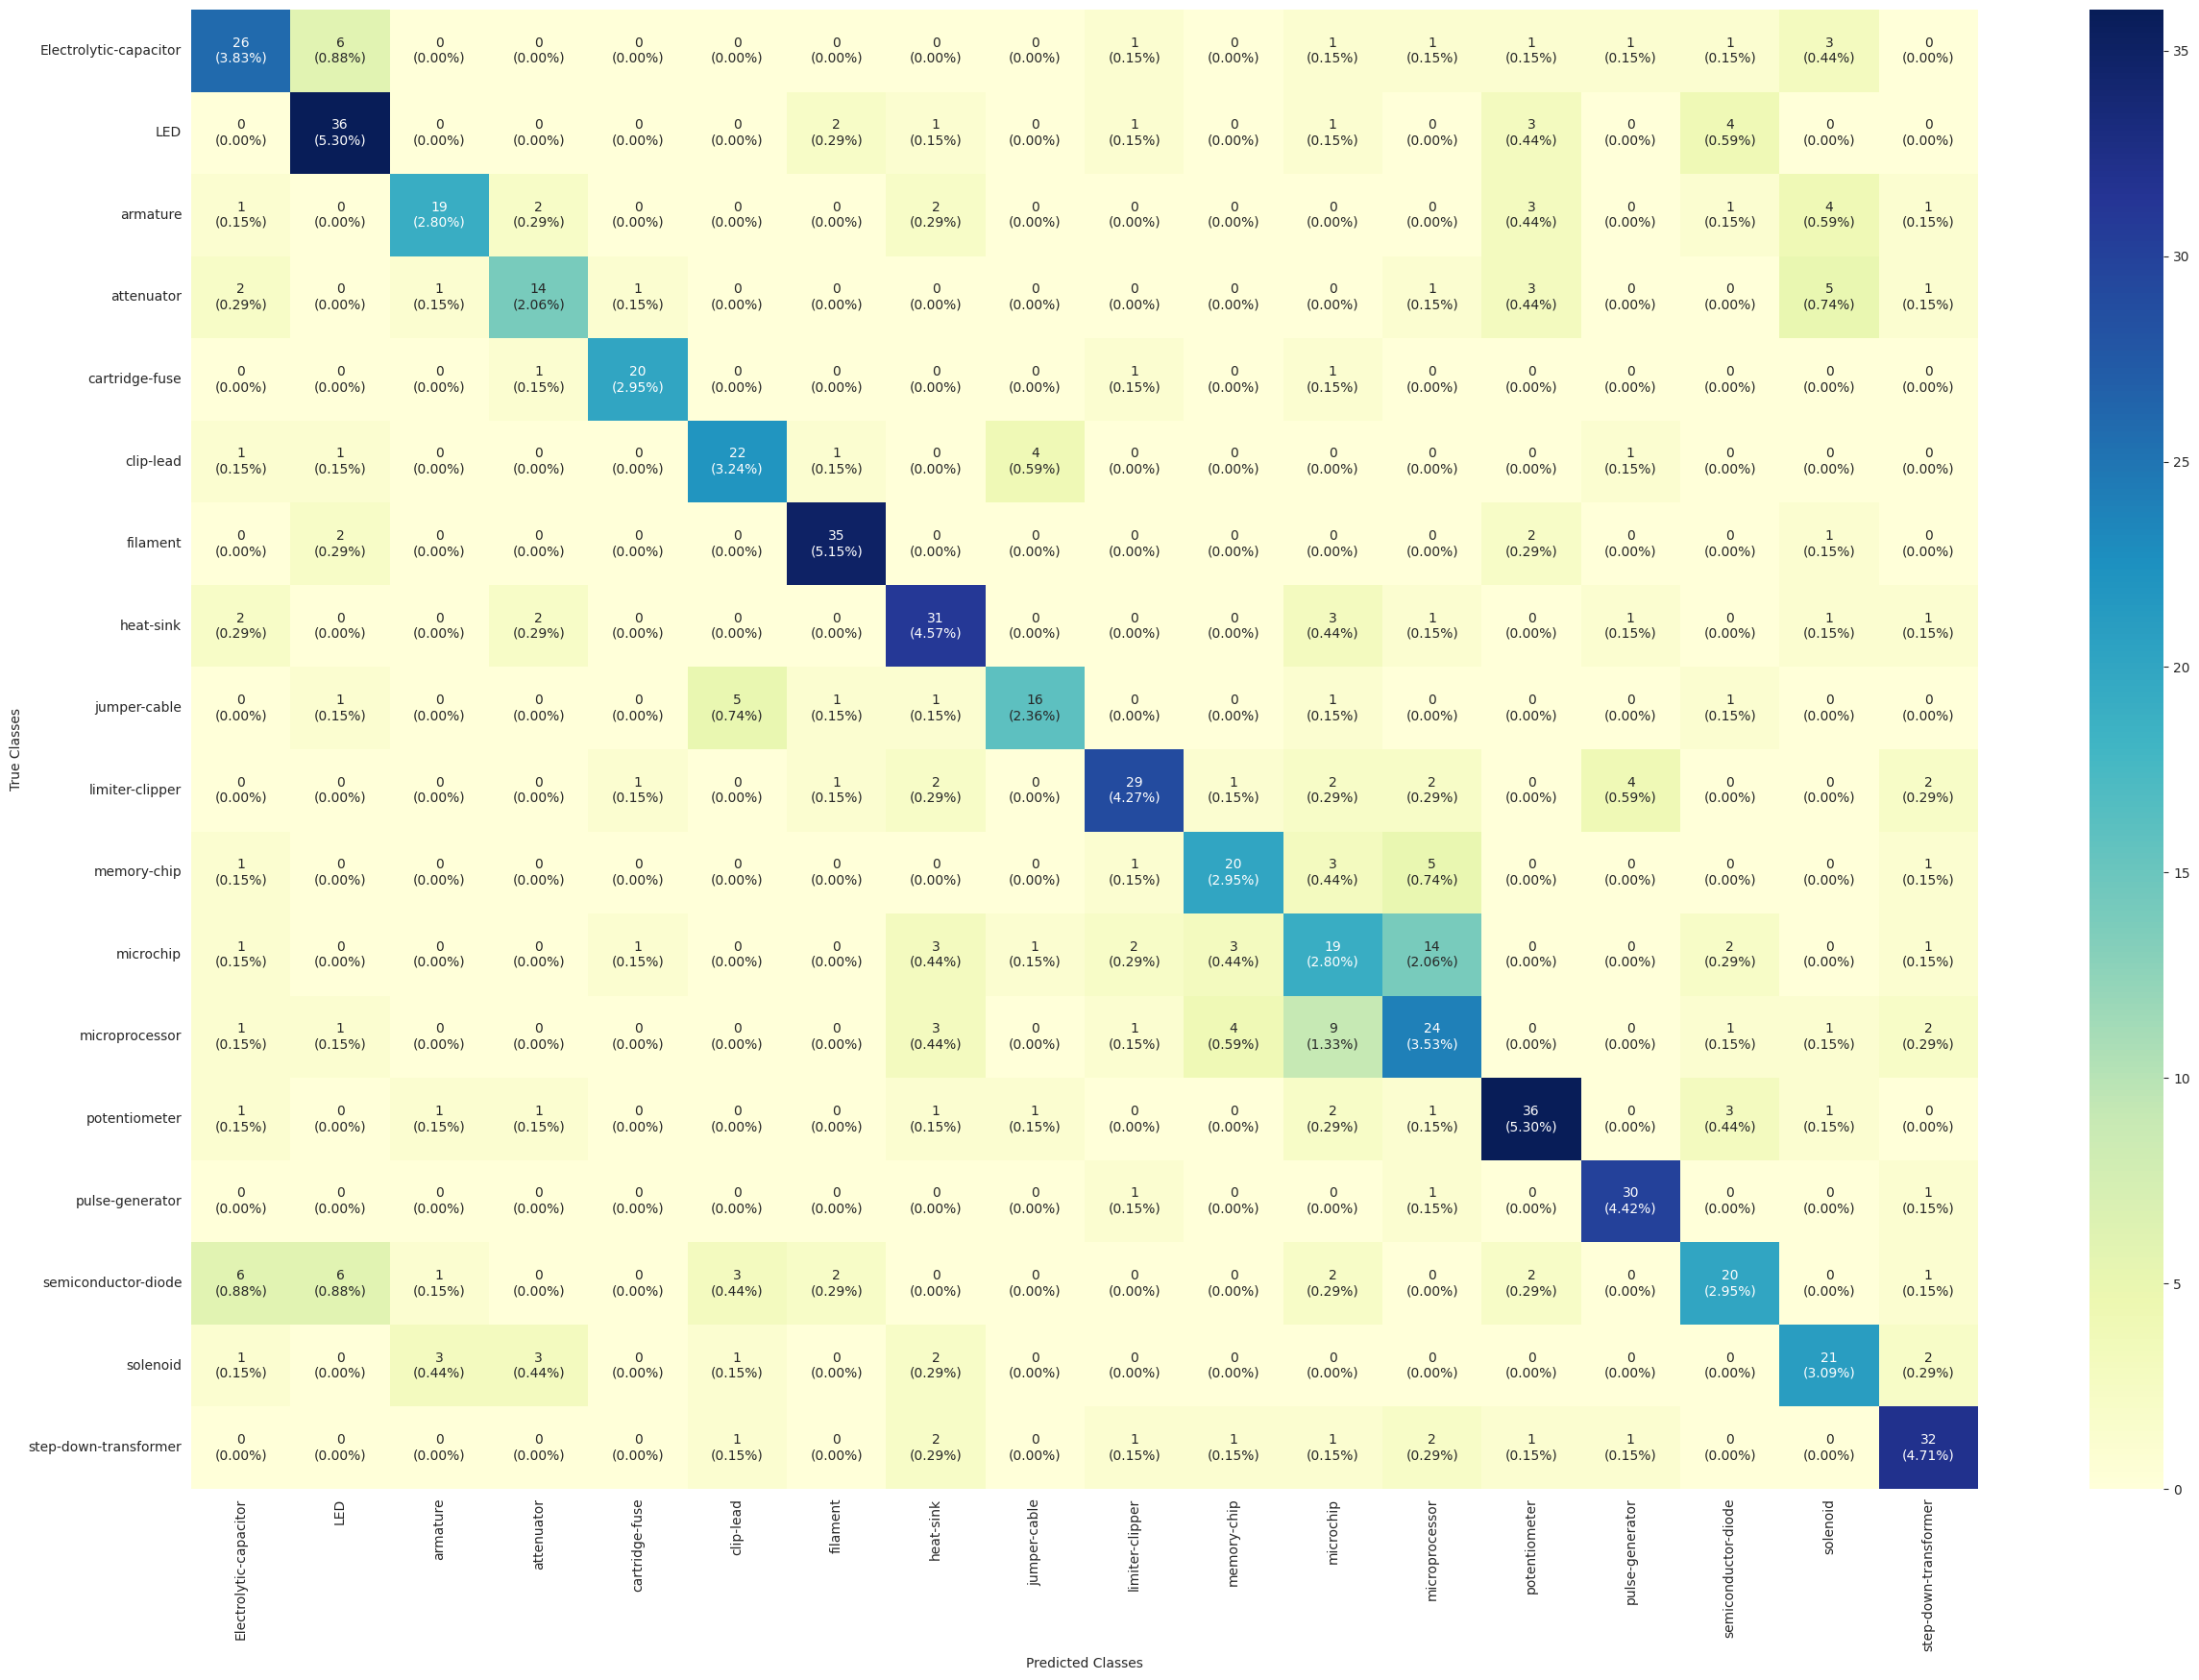

In [47]:
cf_mtx = confusion_matrix(y_true, y_hat)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(18,18)

plt.figure(figsize = (30, 20))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [48]:
print(classification_report(y_true, y_hat, target_names=labels.values()))

                        precision    recall  f1-score   support

Electrolytic-capacitor       0.60      0.63      0.62        41
                   LED       0.68      0.75      0.71        48
              armature       0.76      0.58      0.66        33
            attenuator       0.61      0.50      0.55        28
        cartridge-fuse       0.87      0.87      0.87        23
             clip-lead       0.69      0.73      0.71        30
              filament       0.83      0.88      0.85        40
             heat-sink       0.65      0.74      0.69        42
          jumper-cable       0.73      0.62      0.67        26
       limiter-clipper       0.76      0.66      0.71        44
           memory-chip       0.69      0.65      0.67        31
             microchip       0.42      0.40      0.41        47
        microprocessor       0.46      0.51      0.48        47
         potentiometer       0.71      0.75      0.73        48
       pulse-generator       0.79      

# **WRONG PREDICT**

In [49]:
y_true = np.array(y_true)
print(y_true.shape)

(679,)


In [50]:
errors = (y_true - y_hat != 0)
error_indices = np.where(errors)[0]
y_true_errors = y_true[error_indices]
y_hat_errors = y_hat[error_indices]


In [51]:
# Menghitung jumlah total prediksi
total_predictions = y_true.shape[0]

# Menghitung jumlah prediksi yang salah
total_errors = y_true_errors.shape[0]

# Menghitung persentase prediksi yang salah
error_percentage = (total_errors / total_predictions) * 100

print(f"Jumlah total prediksi: {total_predictions}")
print(f"Jumlah prediksi yang salah: {total_errors}")
print(f"Persentase prediksi yang salah: {error_percentage}%")

Jumlah total prediksi: 679
Jumlah prediksi yang salah: 229
Persentase prediksi yang salah: 33.726067746686304%


In [52]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

In [ ]:
from google.colab import files

# Upload gambar
uploaded = files.upload()

import cv2
import numpy as np
from PIL import Image

# Load the saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Praktikum_semester7/UAP/model_MNV2.h5')

# Assuming 'uploaded' contains the uploaded image
for fn in uploaded.keys():
  # Load and preprocess the image
  img_path = fn
  img = Image.open(img_path).convert('RGB')  # Ensure the image is in RGB format
  img = img.resize((224, 224), Image.LANCZOS)  # Resize the image
  img_array = np.array(img) / 255.0  # Normalize pixel values
  img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension

  # Make a prediction
  predictions = model.predict(img_array)
  predicted_class = np.argmax(predictions)

  # Get prediction percentage
  confidence = predictions[0][predicted_class] * 100 # Get the confidence score for the predicted class

  # Get class labels from the training generator
  labels = {value: key for key, value in train_generator.class_indices.items()}
  predicted_label = labels.get(predicted_class)

  print(f"The predicted label for {fn} is: {predicted_label} with {confidence:.2f}% confidence.")

Saving Corn_Common_Rust (11).jpg to Corn_Common_Rust (11) (1).jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
The predicted label for Corn_Common_Rust (11) (1).jpg is: Common_Rust with 99.83% confidence.


In [53]:
model.save('/content/drive/MyDrive/UAP-Machine-Learning/model/model_MNV2.h5')

In [54]:
model.save('/content/drive/MyDrive/UAP-Machine-Learning/model//model_weight_keras_MBNV2.keras')

In [55]:
model.save_weights('/content/drive/MyDrive/UAP-Machine-Learning/model/model_MNV2_weights.weights.h5')

In [56]:
tf.keras.models.save_model(model, '/content/drive/MyDrive/UAP-Machine-Learning/model/model_MNV2.hdf5')